In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import skimage
import sys

from celllens.utils import *
import os
from tqdm import tqdm
from skimage.io import imread
from celllens.preprocessing import *
from celllens.datasets import *
from celllens.celllens import *
import seaborn as sns

## packages for loading dataset deposited on Zenodo
import requests
import tifffile as tiff
import io

## for clearity
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

/home/zhubokai/miniconda3/envs/celllens_debug/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### (optional) If directly starting from a 10X format (e.g. downloading from website)
##### example data were originally retrieved from:
https://www.10xgenomics.com/datasets/human-tonsil-data-xenium-human-multi-tissue-and-cancer-panel-1-standard


In [2]:
## example code

#import scanpy as sc

#adata = sc.read_10x_h5(
#    filename="../data/cell_feature_matrix.h5" # readin data from 10x website download
#)

#df = pd.read_csv(
#    "../data/cells.csv" # readin data from 10x website download
#)
#df.set_index(adata.obs_names, inplace=True)
#adata.obs = df.copy()
#adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()

# add barcode and subset regions
#df['barcode'] = [x for x in range(1,df.shape[0]+1)]

###### this is the code used in paper where we only use subset of the full data; by x y cropping
#dfsub = df.loc[(df.x_centroid > 7000) & (df.x_centroid < 9500) &
#                          (df.y_centroid > 500) & (df.y_centroid < 3500),:]
#dfsub['y_centroid2'] = -1 * dfsub['y_centroid']

###########
# code if there's additional processing for the xenium data eg filtering cells etc
# eg.
# adata_sub = adata[adata.obs_names.isin(dfsub.cell_id)]
# .... additional cleaning
###########

## and then we proceeded to save these (experssion values and the meta data) into .csv format
# eg.
# df_meta = adata_sub.obs
# df_meta.to_csv('../data/Xton_sub_meta.csv', index=False)
# df_norm = pd.DataFrame(adata_sub.X.toarray())
# df_norm.to_csv('../data/Xton_sub_norm.csv', index=False) # and then we put

### For tutorial, we already stored on Zenodo and can retrieve data in .csv format for easier example

In [3]:
# load xenium normalized values
dfnorm_url = 'https://zenodo.org/records/15596524/files/Xton_sub_norm_genenames.csv?download=1'
df_norm = pd.read_csv(dfnorm_url, index_col= 0)
df_norm

,ABCC11,ACE2,ACKR1,ACTA2,ACTG2,ADAM28,ADAMTS1,ADGRE1,ADGRL4,ADH1C,...,TRAC,TREM2,TSPAN19,UBE2C,UMOD,UPK3B,VCAN,VSIG4,VWA5A,VWF
0,0.0,0.0,0.0,0.000000,0.221237,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.481838,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.910560,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.747777,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.486434,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158254,0.0,0.0,0.0,0.000000,0.000000,1.446919,0.000000,0.0,0.000000,0.0,...,0.733969,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158255,0.0,0.0,0.0,0.000000,0.000000,0.832909,0.000000,0.0,0.000000,0.0,...,2.014903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158256,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,1.269024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
158257,0.0,0.0,0.0,0.000000,1.124930,0.000000,0.000000,0.0,0.000000,0.0,...,1.124930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## and read in the meta data
dfmeta_url = 'https://zenodo.org/records/15596524/files/Xton_sub_meta.csv?download=1'
df_meta = pd.read_csv(dfmeta_url)
df_meta

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,barcode,y_centroid2,n_counts,leiden
0,adkkpojc-1,9079.155273,852.034607,210,0,0,0,0,210,388.343764,18.197969,21061,-852.034607,210.0,9
1,adklbgog-1,9053.489258,836.870728,84,0,0,0,0,84,651.920805,37.840939,21062,-836.870728,84.0,9
2,adklbigp-1,9055.033203,858.775208,70,0,0,0,0,70,85.209847,38.924689,21063,-858.775208,70.0,9
3,adklblhc-1,9071.123047,864.167419,187,0,0,0,0,187,67.418284,29.261251,21064,-864.167419,187.0,9
4,adklcljc-1,9058.196289,865.665100,83,0,0,0,0,83,61.909221,34.092970,21065,-865.665100,83.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158254,kpmgdfib-1,7007.816895,3435.540771,48,0,0,0,0,48,44.795002,28.764532,1019380,-3435.540771,48.0,2
158255,kpmgdlan-1,7029.023926,3435.982910,40,0,0,0,0,40,25.106876,18.017344,1019381,-3435.982910,40.0,2
158256,kpmgeemo-1,7024.300781,3437.280762,61,0,0,0,0,61,33.189845,22.307188,1019382,-3437.280762,61.0,2
158257,kpmgfcmg-1,7038.618652,3437.683105,25,0,0,0,0,25,22.578126,14.269376,1019383,-3437.683105,25.0,3


<Axes: xlabel='x_centroid', ylabel='y_centroid2'>

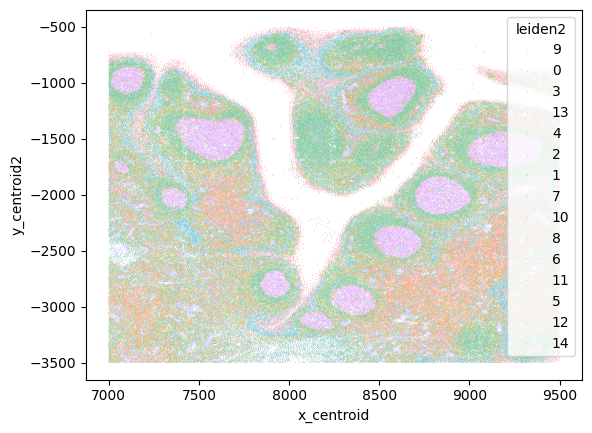

In [5]:
# quick viz of data
df_meta['leiden2'] = df_meta['leiden'].astype(str)
sns.scatterplot(df_meta, x = 'x_centroid', y = 'y_centroid2', hue = 'leiden2', s = 0.3)

### then we load the image file (xenium supplied with ome.tiff format in their database)

In [8]:
import pathlib
import requests, tempfile
from pyometiff import OMETIFFReader

## these packages not updated in pypi yet need to manually install - got lazy I will update soon!!
# pip install pathlib
# pip install pyometiff

# we have deposited the tutorial data onto zenodo for convinient loading
img_url = 'https://zenodo.org/records/15596524/files/morphology_focus.ome.tif?download=1'

# Fetch the file from the URL
response = requests.get(img_url)
response.raise_for_status()

with tempfile.NamedTemporaryFile(suffix=".ome.tif", delete=False) as tmp:
    tmp.write(response.content)
    tmp_path = tmp.name

reader = OMETIFFReader(fpath=tmp_path)
img_array, metadata, xml_metadata = reader.read()

# takes a little time to download - ~2gb image

Key not found: 'NoneType' object has no attribute 'iter'
Key not found: 'NoneType' object has no attribute 'iter'


#### (specific for this data) reformat images to 2 channels

In [9]:
## in this specific example there is only nulcear staining but it is fine
## just make a dummy second channel with no signal

img_array2 = np.stack([img_array, np.zeros_like(img_array)], axis=-1)
img_array2.shape

(40869, 53926, 2)

### continue checking images

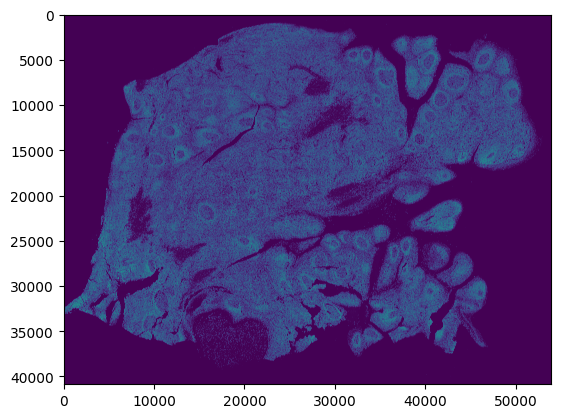

In [10]:
## this part solely for better viz, threshold not actually used
temp1 = img_array.copy()
temp1[temp1 >9000] = 9000
## end

plt.imshow(temp1) # this is nuclear image
plt.show()
### note this is the image of the full dataset (on the .csv they are subseted but that is fine because locations can be translated between)

In [11]:
### one thing to note is that in xenium, the spatial corrdinates from the meta file is not exactly the pixel location in the .tiff
## but translation is straightforward, which is just a linear projection
# detail see 10x (https://kb.10xgenomics.com/hc/en-us/articles/11636252598925-What-are-the-Xenium-image-scale-factors?utm_source=chatgpt.com)

df_meta['new_x'] = (df_meta['x_centroid'] // 0.2125).astype(int)
df_meta['new_y'] = (df_meta['y_centroid'] // 0.2125).astype(int)

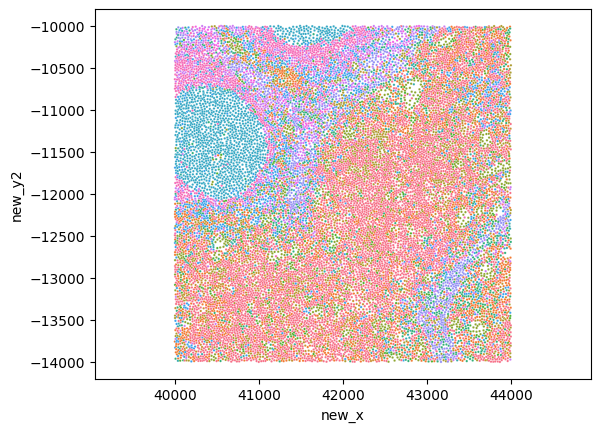

In [12]:
## then we quickly check if the cell location is consistent with image location

## locations in df_meta
df_meta['new_y2'] = -1 * df_meta['new_y'] # this is just for seaborn plotting reverse y axis

temp = df_meta.loc[(df_meta.new_x > 40000) & (df_meta.new_x < 44000) & # just a random place here
              (df_meta.new_y > 10000) & (df_meta.new_y < 14000), :]

sns.scatterplot(data = temp, x = 'new_x', y = 'new_y2', hue = 'leiden2', s=3, legend=False)
plt.axis('equal')  # Ensures equal scaling for x and y axes
plt.show()

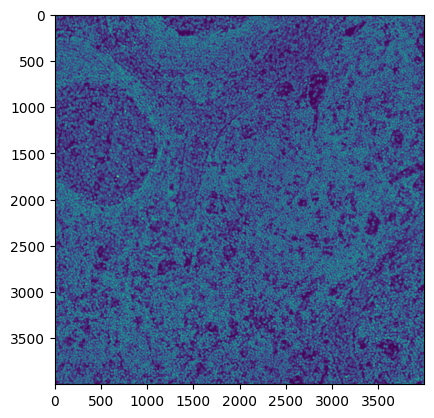

In [13]:
## check the location in image pixel space
plt.imshow(temp1[10000:14000, 40000:44000]) # here we note the x,y loc in df_meta is flipped in image x, y for xenium
## this need to be noted otherwise will give error

### All set, start CellLENS

In [14]:
# some quick final formating
gene_names = df_norm.columns.to_list()
df_norm_withXY = df_norm
df_norm_withXY['new_x'] = df_meta['new_x']
df_norm_withXY['new_y'] = df_meta['new_y']

In [15]:
xenium_dataset = LENS_Dataset(df_norm_withXY,
                              features_list=gene_names, #since all genes
                              nbhd_composition=15,
                              feature_neighbor=15,
                              spatial_neighbor=15,
                              path2img='../data/processed_data/', # location to store cropped images
                             use_transform = False) # processed image saving location - in later steps

In [16]:
## total of 158k cells in this data

import warnings
warnings.filterwarnings('ignore')

xenium_dataset.initialize(cent_x="new_y", # x loc of cells
                          cent_y="new_x", # y loc of cells - note here flipped per previous mention
                          celltype="feature_labels", # default option - run leiden to initialize the clusters
                          pca_components=30, # PCA components to use, user decide - doing 30 here 
                          cluster_res=0.5) # leiden initialization resolution

Leiden clustering identified 13 clusters as input population identity.
Calculating cell neighborhood composition matrix...
Constructing the graph...
Done!


### start processing images

In [17]:
size = 512
truncation = 0.8

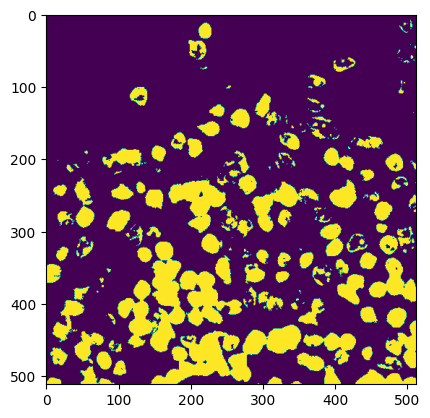

In [18]:
## example check
img_test = img_array2[:,:,0].copy() # just showing nuclear image for example
## binarize
thresh = np.quantile(img_test, truncation)
img_test[img_test <= thresh] = 0
img_test[img_test > thresh] = 1
## quick check
example = [10000,40000] # random place
plt.imshow(img_test[(example[0] - int(size/2)):(example[0] + int(size/2)), # example of one single crop, for a cell centered at 3500,3500 (if theres a cell)
           (example[1] - int(size/2)):(example[1] + int(size/2))])

In [19]:
# note this will create a folder with single crops images (same number of cells)
# this step (on this data) takes ~ 40mins - lots of images!!!.
xenium_dataset.prepare_images(img_array2,
                               size,
                               truncation,
                               aggr = [[0], [1]],
                               pad=1000, # pad size at boundary
                               verbose=False)
# note saving images of 158k cells will take up some space - after CNN training feel free to delete it.
# might be memory hungry at this step though.... (perhaps something to improve here??)

Saving images...


100%|██████████| 158259/158259 [41:35<00:00, 63.41it/s]


### Finally now start the actual CelllENS process

#### part 1: LENS-CNN (skip if ignoring the morphology part)

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
xenium_celllens = CellLENS(xenium_dataset,
                           device,
                           cnn_model='CNN',
                           cnn_latent_dim=128,
                           gnn_latent_dim=32,
                           input_channel_num=2
                          ) # generally these parameters no need to change

In [21]:
xenium_celllens.fit_lens_cnn(
                     batch_size=64,
                     learning_rate=1e-4,
                     n_epochs=5, #### NOTE: setting to 5 for saving time on this tutorial, should set to 200 - 400
                     loss_fn='MSELoss',
                     OptimizerAlg='Adam',
                     optimizer_kwargs={},
                     SchedulerAlg=None,
                     scheduler_kwargs={},
                     num_workers = 8,
                     use_amp = True,
                     print_every=1000, # could print more if want to monitor loss more
                     cnn_model='CNN') # generally other parameters dont need to be changed - unless for specfic reason


=============Training convolutional neural network============

Epoch 1/5


Epoch 1: 100%|██████████| 2473/2473 [01:14<00:00, 33.21batch/s, loss=0.016257]


Epoch 2/5


Epoch 2: 100%|██████████| 2473/2473 [00:38<00:00, 64.04batch/s, loss=0.011854]


Epoch 3/5


Epoch 3: 100%|██████████| 2473/2473 [00:38<00:00, 63.61batch/s, loss=0.009676]


Epoch 4/5


Epoch 4: 100%|██████████| 2473/2473 [00:39<00:00, 63.33batch/s, loss=0.008401]


Epoch 5/5


Epoch 5: 100%|██████████| 2473/2473 [00:39<00:00, 63.33batch/s, loss=0.007327]


In [22]:
xenium_celllens.get_cnn_embedding(batch_size=512, # generally these parameters no need to change
                                  path2result='../CellLENS_saveouts')


=====Save CNN Embedding!============



#### part 2: Train LENS GNN

In [23]:
xenium_celllens.get_lens_embedding(round=5,
                                   k=32,
                                   learning_rate=1e-3,
                                   n_epochs=5000,
                                   loss_fn='MSELoss',
                                   OptimizerAlg='Adam',
                                   optimizer_kwargs={},
                                   SchedulerAlg=None,
                                   scheduler_kwargs={},
                                   verbose=True) # generally these parameters do not need to change

===Epoch 500, the training loss is 0.00529946==
===Epoch 1000, the training loss is 0.00438076==
===Epoch 1500, the training loss is 0.00391193==
===Epoch 2000, the training loss is 0.00358400==
===Epoch 2500, the training loss is 0.00334818==
===Epoch 3000, the training loss is 0.00319272==
===Epoch 3500, the training loss is 0.00304569==
===Epoch 4000, the training loss is 0.00295065==
===Epoch 4500, the training loss is 0.00287064==
===Epoch 5000, the training loss is 0.00281241==

=========Get Current Round CellLENS Embedding!============

===Epoch 500, the training loss is 0.00566572==
===Epoch 1000, the training loss is 0.00465388==
===Epoch 1500, the training loss is 0.00417784==
===Epoch 2000, the training loss is 0.00387604==
===Epoch 2500, the training loss is 0.00367716==
===Epoch 3000, the training loss is 0.00349875==
===Epoch 3500, the training loss is 0.00335895==
===Epoch 4000, the training loss is 0.00325684==
===Epoch 4500, the training loss is 0.00316566==
===Epoch 5

#### part 3: LENS Clustering & Visualization

In [24]:
# the resulting CellLENS embedding is stored here:
pd.DataFrame(xenium_celllens.lens_embedding)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-11.391343,4.072087,1.024942,-4.524926,-1.084199,3.442647,-3.603529,-8.314380,12.868779,-5.344472,...,0.224176,1.063737,-1.470685,-1.290764,-0.210802,0.237010,-0.467305,0.982723,1.449015,-0.164777
1,-8.529206,3.537894,0.454038,-3.001373,-1.251076,3.207647,-3.435443,-5.419091,11.246877,-3.114575,...,0.582644,-0.045128,-0.216803,-0.727166,-0.212635,-0.239707,-0.082029,0.709670,-0.049964,-0.490564
2,-10.451694,3.763621,0.758073,-3.779339,-0.854165,2.985087,-3.636105,-6.510042,13.086382,-4.522628,...,1.161476,-0.245332,-0.339422,-0.467131,-0.692011,-0.201187,-0.672789,0.633882,0.523230,0.100053
3,-12.994293,5.108516,0.017227,-4.342631,-1.894010,4.472895,-5.428693,-9.266501,16.500883,-6.507546,...,0.446166,-0.684605,-0.154575,-0.528707,-0.241958,-1.188821,0.459966,0.552375,0.507743,-0.205559
4,-10.271154,3.318050,0.171821,-3.027672,-0.981200,2.904900,-3.682069,-7.354962,11.730774,-3.502790,...,0.700146,-0.466394,-0.697725,-0.578858,-0.639674,-1.135975,-0.144327,1.466458,0.914074,-0.408554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158254,-6.243805,0.026795,-2.113949,-0.135114,1.144887,-0.244673,-0.047334,0.670087,0.727997,1.726875,...,0.227703,-0.326370,-0.018118,0.170700,0.295653,-0.255314,-0.326290,0.358815,-0.392781,0.097207
158255,-9.127236,-0.031415,-4.397942,-0.290779,2.323254,0.235426,-0.783340,0.190820,-0.241321,0.360986,...,0.237008,-0.170213,0.018630,-0.317088,0.037238,-0.120645,0.042288,0.114598,0.121213,0.123619
158256,-8.343119,0.067027,-3.039481,-0.791845,1.475859,-0.625165,0.371193,1.628569,0.156947,0.241806,...,0.327179,-0.108621,0.121830,-0.035495,0.153029,0.180771,-0.258763,0.073485,0.219423,0.034348
158257,-4.082580,1.355845,0.489074,0.312318,-0.310976,-0.002947,1.562943,1.086802,0.680309,1.985011,...,-0.223389,0.080849,-0.193852,-0.050815,0.068116,-0.081816,-0.031350,-0.042366,-0.020067,-0.054885


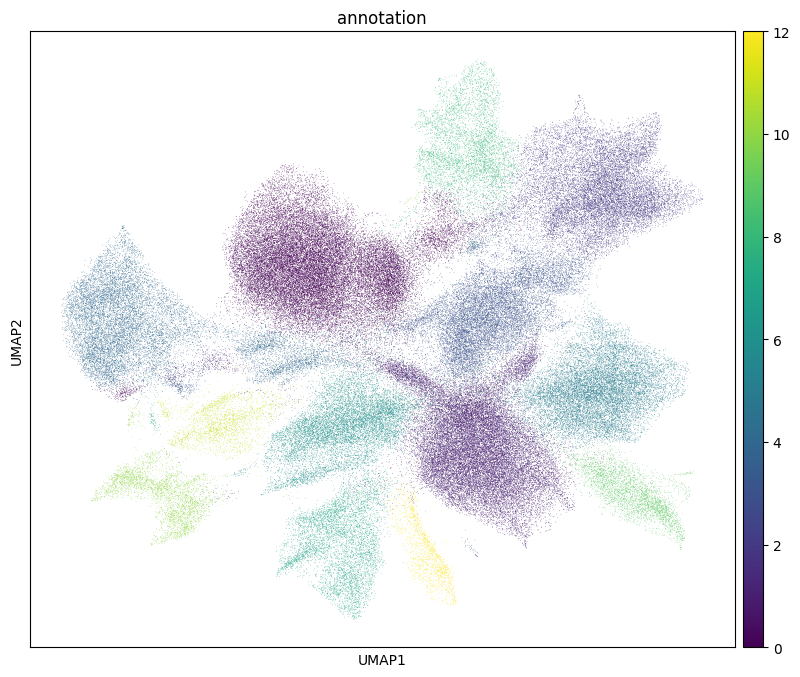

In [31]:
# we also have a wrapper function for quick UMAP visualization of the CellLENS embedding
xenium_celllens.visualize_umap(xenium_celllens.lens_embedding, xenium_dataset.df['feature_labels']) # here coloring with original leiden clusters

In [32]:
xenium_celllens.get_lens_clustering(neighbor=15, # standard leiden parameter
                                    resolution=1.0, # resolution for leiden - specific
                                    entropy_threshold=0.75, # CellLENS parameter - generally no change needed
                                    concen_threshold=1, # CellLENS parameter - generally no change needed
                                    max_breaks=3, # CellLENS parameter - generally no change needed
                                    size_lim=50 # CellLENS parameter - smallest cluster size allowed
                                   )

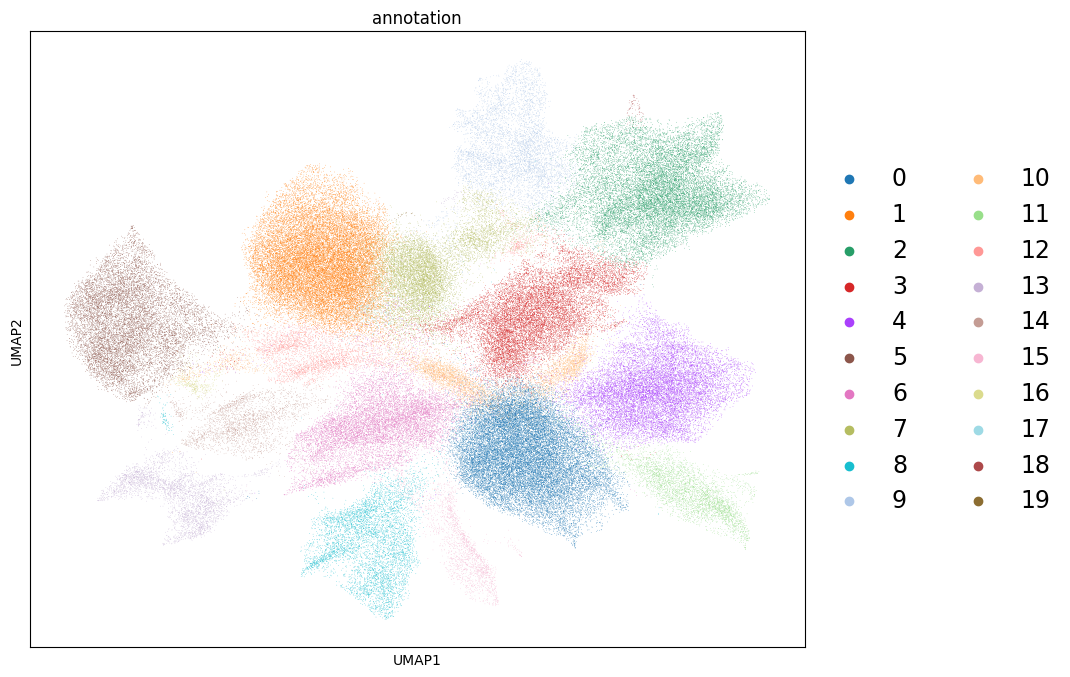

In [33]:
xenium_celllens.visualize_umap(xenium_celllens.lens_embedding, xenium_celllens.lens_clustering)

In [ ]:
# the clustering results can also be easily accessed here
#murine_celllens.lens_clustering